In [11]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import importlib

import matplotlib.pyplot as plt
#import seaborn as sns
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
#%matplotlib widget

from tqdm import tqdm
import io, sys
from contextlib import redirect_stdout, redirect_stderr

import os

import h5py
import hdf5plugin

import sys
sys.path.append('./XPCS_library/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')
XPCS.set_expvar(1350, 1350, 7)

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

# RAW FOLDER PATH
raw_folder = '../RAW_DATA/'
masks_folder = '../masks/'

## Load masks

In [12]:
e4m_htmask = np.load(masks_folder+'e4m_htmask_copper_foil_30um_1_1'+'.npy')
e4m_mask = np.load(masks_folder+'e4m_mask'+'.npy')
bs_mask = np.load(masks_folder+'bs_mask_copper_foil_30um'+'.npy')

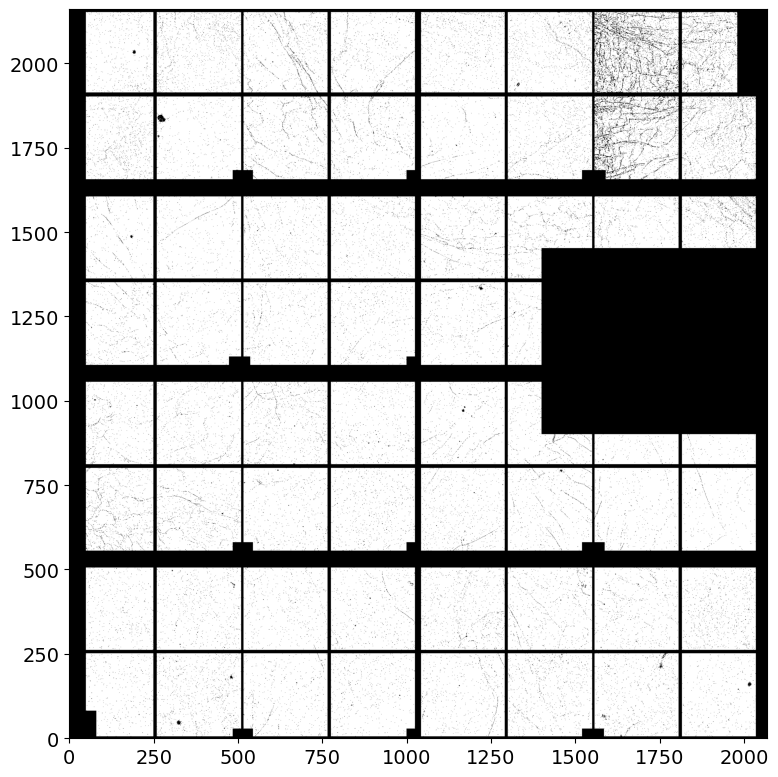

In [13]:
plt.figure(figsize=(8, 8))
plt.imshow((e4m_mask*e4m_htmask*bs_mask).reshape(Nx,Ny), cmap='gray', origin='lower')
plt.tight_layout(); plt.show()

## XPCS scan (Q = 1.61, 10 min @ 50ms (12000fm)) (GeO2_8-21p67-V2, dataset 1, scan 6)

In [14]:
#######################################
sample_name = 'vycor'
Ndataset = 1
Nscan = 7
ID10.Nfmax_dense_file = 10000
load_mask = e4m_mask*e4m_htmask*bs_mask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

Nfi, Nff = None, None
e4m_data = ID10.load_dense_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff,  n_jobs=1, load_mask=load_mask, tosparse=False)

#############################
command = mtimescan 0.01 1 10000
Ei = 9.699998837562536
itime = 0.0101
theta = 0.0
Q = 0.0
#############################

Loading dense array ...
	 -> loading file eiger4m_v2_frame_0_00000.h5 (1/1 loops)
0 1 None None 0 10000
Done!
Concatenating vectors ...
Done!
--------------------------------------------------------
Memory usage (numpy.array): 124.204 GB
--------------------------------------------------------


################################################################################
Maximum count in the hull run -> 14475
# of pixels above Ith_high treshold ->  1567 pixels (of 4471016 => 0.05 %)
################################################################################



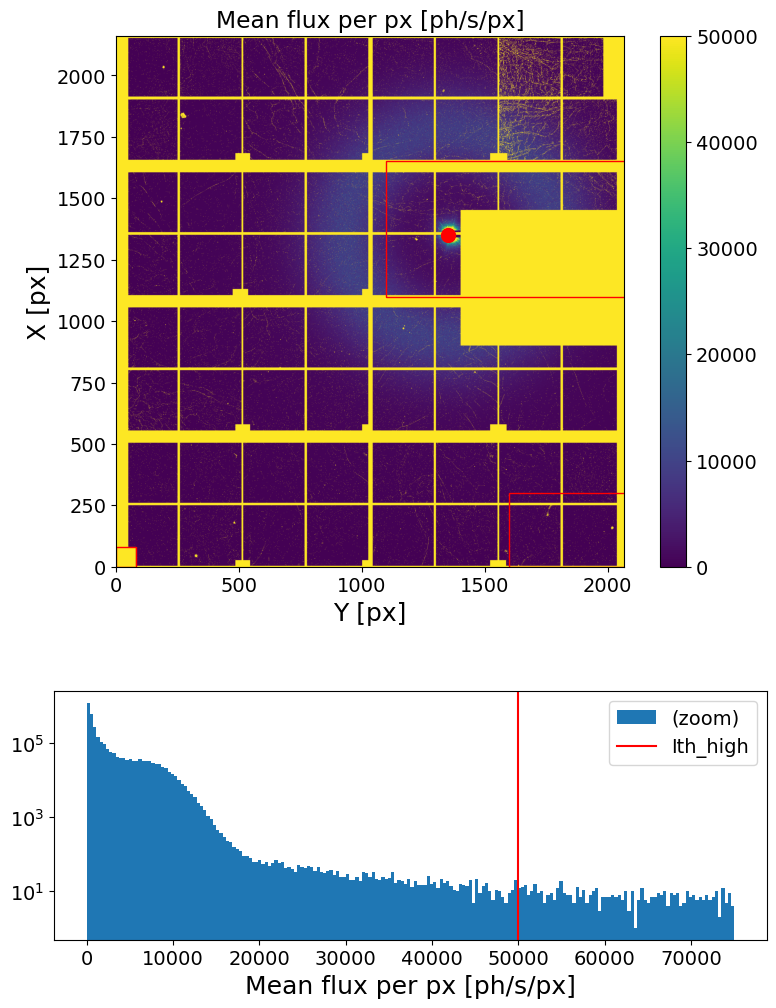

In [21]:
geom = [{'geom':'Rectangle', 'x0':1100, 'y0':1100, 'xl':550, 'yl':1950, 'inside':False},
        {'geom':'Rectangle', 'x0':0, 'y0':0, 'xl':80, 'yl':80, 'inside':False},
        {'geom':'Rectangle', 'x0':0, 'y0':1600, 'xl':300, 'yl':2000, 'inside':False}     
        ]
XPCS.set_expvar(1350, 1350, 7)

XPCS.gen_plots4mask(e4m_data, itime, mask = load_mask,Ith_high=50000, Nff=3, mask_geom=geom,)

#################################################
Masked area =  84.77310302624727 %
#################################################



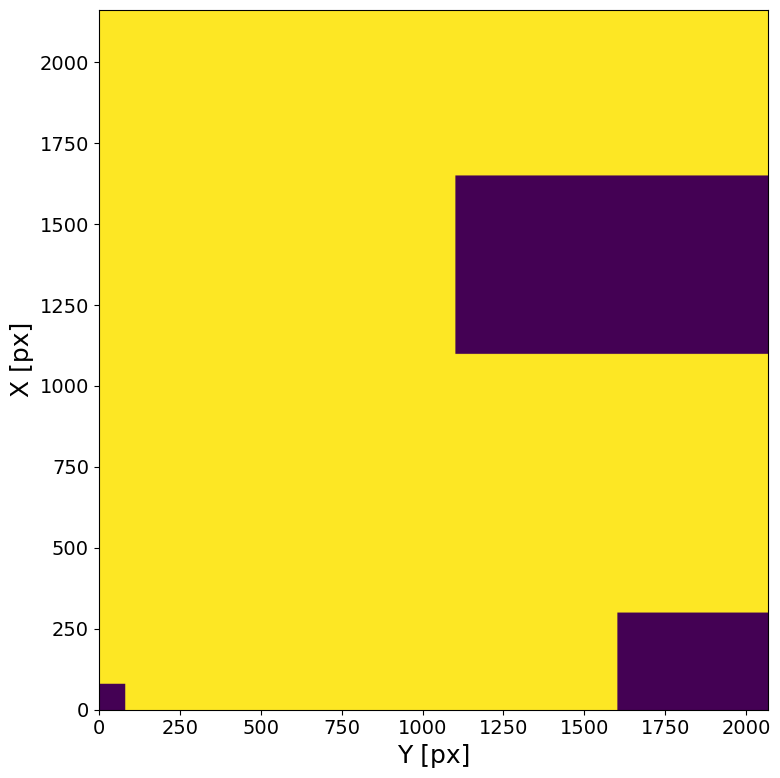

In [22]:
bs_mask = XPCS.gen_mask(mask_geom=geom, hist_plots=False)

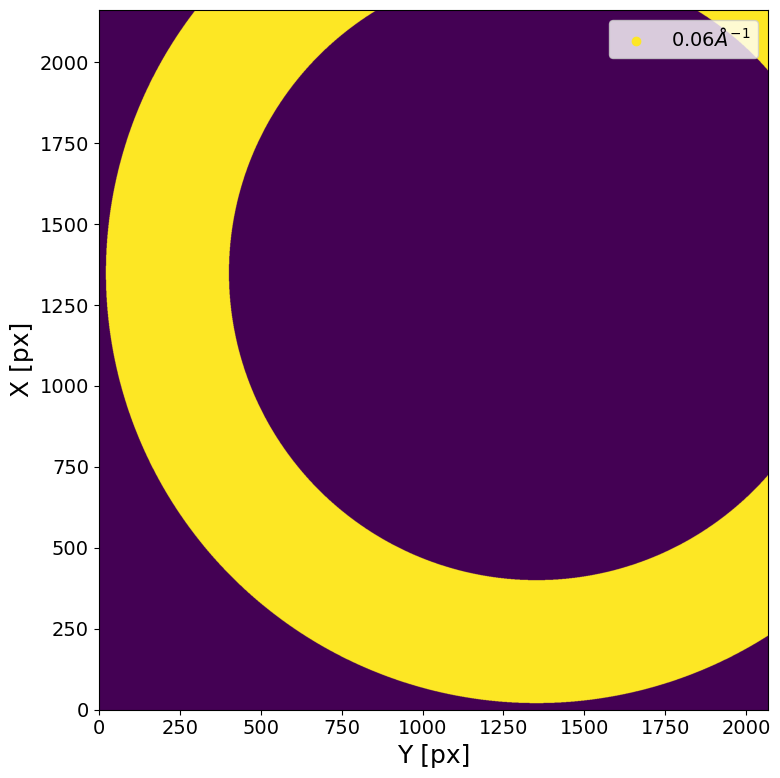

In [23]:
Qmask = XPCS.gen_Qmask(Ei, theta, .06, .01, Qmap_plot=False)

In [18]:
###################
Nfi = None
Nff = None
Lbin = 1
###################

G2t = XPCS.get_G2t(e4m_data, mask=None, Nfi=Nfi, Nff=Nff, Lbin=None)
t, g2 = XPCS.get_g2(itime*Lbin, G2t, cython=False)
t_mt, g2_mt = XPCS.get_g2_mt(itime*Lbin, g2)

Loading frames ...
Done! (elapsed time = 33.76 s)
Computing G2t (using MKL library)...
Done! (elapsed time = 134.55 s)
	 | 10000 X 10000 squared matrix
	 | memory usage (np.array @ float32) = 0.373 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 12.81 s)

Computing g2...
Done! (elapsed time = 0.44 s)



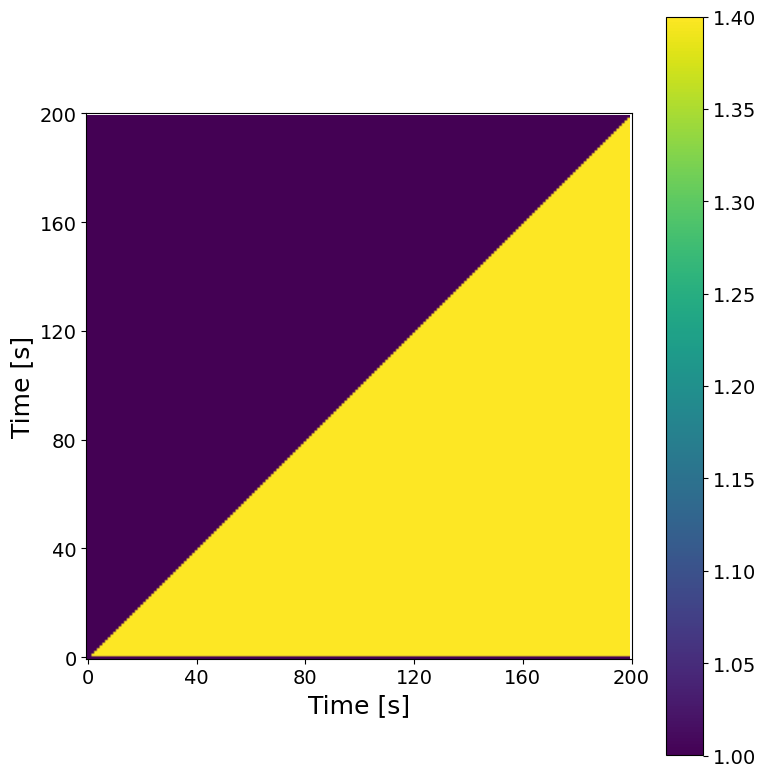

In [19]:
############################
t1, t2 = 0, 200
vmin, vmax = 1.0, 1.4
############################
XPCS.plot_G2t(G2t, vmin, vmax, t1=t1, t2=t2, sigma_filter=None)

#######################
tau = 16.03 +/- 0.03 s
beta = 1.57 +/- 0.01
c = 0.451 +/- 0.001
y0 = 5.317 +/- 0.0
#######################


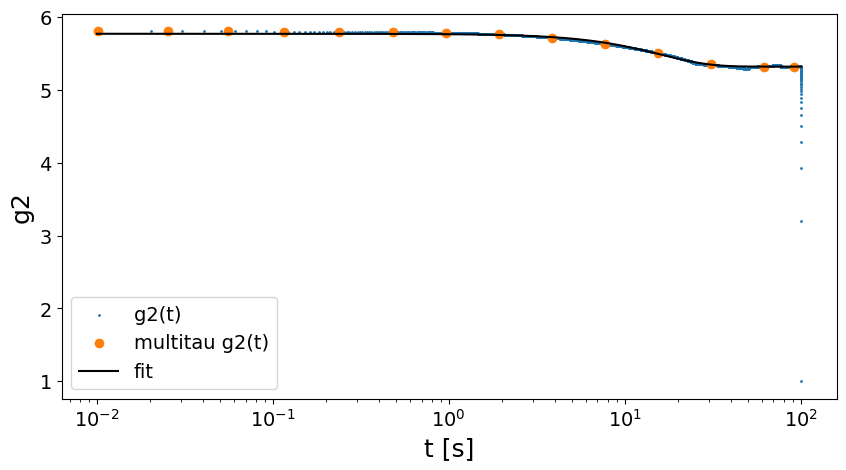

In [20]:
# DATA PLOT
plt.figure(figsize=(10,5))
plt.scatter(t, g2, s=1, label = 'g2(t) ')
plt.scatter(t_mt, g2_mt, label='multitau g2(t)')

plt.xlabel('t [s]')
#plt.ylim(.98,1.02)
plt.ylabel('g2')
plt.xscale('log')

# FIT
popt, pcov = curve_fit(decorelation_f, t[t<1e2], g2[t<1e2], p0=[1, 1, 1, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
fit_out= {'tau':popt[0], 'beta':popt[1], 'c':popt[2], 'y0':popt[3], 'dtau':np.sqrt(pcov[0,0]), 'dbeta':np.sqrt(pcov[1,1]), 'dc':np.sqrt(pcov[2,2]), 'dy0':np.sqrt(pcov[3,3])}

x = np.linspace(1e-2, t[-1], 100000)
y = decorelation_f(x, *popt)
plt.plot(x, y, label='fit', c='black')

print('#######################')
print('tau =', round(fit_out['tau'], 2), '+/-', round(fit_out['dtau'], 2), 's')
print('beta =', round(fit_out['beta'], 2), '+/-', round(fit_out['dbeta'], 2))
print('c =', round(fit_out['c'], 3), '+/-', round(fit_out['dc'], 3))
print('y0 =', round(fit_out['y0'], 3), '+/-', round(fit_out['dy0'], 3))
print('#######################')

plt.legend()